In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pickle
import scorecardpy as sc
import pwlf
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
from scipy.stats import zscore
from datetime import datetime
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

In [4]:
df = pd.read_pickle('Q6_merged_df.pkl')
breaks = pd.read_pickle('Q2_breaks.pkl')
woe_iv_cf_name_df = pd.read_pickle('Q3_X_train_refit.pkl')
pd_model = pd.read_pickle('Q3_pd_model.pkl')
scorecard = pd.read_pickle('Q3_scorecard.pkl')

In [6]:
_, df_sample = sc.split_df(df, y = 'loan_status', ratio = 0.8, seed=251316935).values()
df_sample.loan_status = ((df_sample.loan_status == 'Charged Off') | (df_sample.loan_status == 'Default'))
bins_adj = sc.woebin(df_sample, y="loan_status", breaks_list=breaks)
df_woe = sc.woebin_ply(df_sample, bins_adj)
df_woe = df_woe.loc[:,woe_iv_cf_name_df.columns]
df_sample['pd'] = pd_model.predict_proba(df_woe)[:,1]
df_sample['score'] = sc.scorecard_ply( df_sample, scorecard, print_step=0)
df_sample.issue_d = pd.to_datetime(df_sample.issue_d)
pickle.dump(df_sample, open('Q7_df_sample.pkl','wb'))

In [26]:
df_sample = pd.read_pickle('Q7_df_sample.pkl')

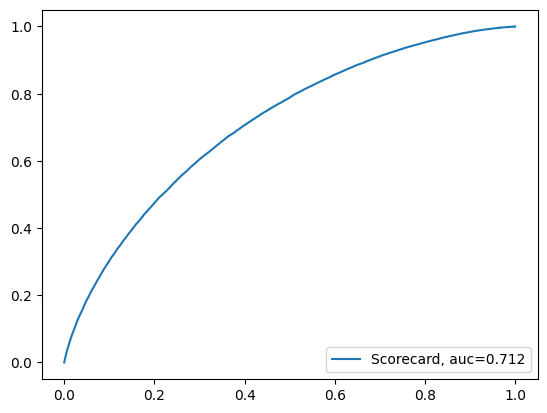

In [32]:
fpr, tpr, thresholds = roc_curve(df_sample['loan_status'], df_sample['pd'])
auc = np.round(roc_auc_score(y_true = df_sample['loan_status'], y_score = df_sample['pd']), decimals = 3)
plt.plot(fpr,tpr,label="Scorecard, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [33]:
piecewise_AUC = pwlf.PiecewiseLinFit(fpr, tpr)

In [ ]:
res = piecewise_AUC.fit(10)
pickle.dump(res, open('Q7_res.pkl','wb'))

In [35]:
res = pd.read_pickle('Q7_res.pkl')

In [36]:
ROC_curve = pd.DataFrame({'fpr': fpr, 'threshold': thresholds})
cuts = piecewise_AUC.fit_with_breaks(res)
xHat = np.linspace(min(fpr), max(fpr), num=10000)
yHat = piecewise_AUC.predict(xHat)
pbb_cuts = np.zeros_like(res)
i = 0

for fpr in res:
  temp = ROC_curve.loc[np.round(ROC_curve.fpr, 2) == np.round(fpr, 2), 'threshold']
  pbb_cuts[i] = np.mean(temp)
  i += 1

pbb_cuts = np.flip(pbb_cuts)
pbb_cuts = np.append(pbb_cuts, 1)
pbb_cuts = np.insert(pbb_cuts, 0, 0)
pbb_cuts

array([0.        , 0.06167588, 0.24830446, 0.333121  , 0.40458262,
       0.46042976, 0.52002545, 0.59474766, 0.66441342, 0.71810854,
       0.7847515 , 0.86212459, 1.        ])

In [37]:
pd_cut = pd.cut(df_sample['pd'], pbb_cuts)
df_sample["pd_cut"] = pd_cut

PDs_Tab = pd.crosstab(df_sample["pd_cut"],
                      df_sample['loan_status'],
                      normalize = False)
print(PDs_Tab)
pd_final = PDs_Tab[1] / (PDs_Tab[0] + PDs_Tab[1])
pd_final

loan_status      False  True
pd_cut                      
(0.0, 0.0617]      329    16
(0.0617, 0.248]  34056  1968
(0.248, 0.333]   30348  3321
(0.333, 0.405]   28354  4470
(0.405, 0.46]    22250  4566
(0.46, 0.52]     22262  5759
(0.52, 0.595]    24332  8116
(0.595, 0.664]   18150  8146
(0.664, 0.718]   10220  5986
(0.718, 0.785]    8092  6436
(0.785, 0.862]    3599  4213
(0.862, 1.0]       411   723


pd_cut
(0.0, 0.0617]      0.046377
(0.0617, 0.248]    0.054630
(0.248, 0.333]     0.098637
(0.333, 0.405]     0.136181
(0.405, 0.46]      0.170271
(0.46, 0.52]       0.205524
(0.52, 0.595]      0.250123
(0.595, 0.664]     0.309781
(0.664, 0.718]     0.369369
(0.718, 0.785]     0.443007
(0.785, 0.862]     0.539299
(0.862, 1.0]       0.637566
dtype: float64

In [40]:
pbb_cuts = [0, 0.40617798, 0.4622412 , 0.52067299, 0.5947163 , 0.66481892, 0.71777836, 0.78351013, 1]
df_sample['pd_cut'] = pd.cut(df_sample['pd'], pbb_cuts)
PDs_Tab = pd.crosstab(df_sample["pd_cut"],
                      df_sample['loan_status'],
                      normalize = False)
print(PDs_Tab)
pd_final = PDs_Tab[1] / (PDs_Tab[0] + PDs_Tab[1])
pd_final

loan_status     False  True
pd_cut                     
(0.0, 0.406]    93783  9887
(0.406, 0.462]  22285  4600
(0.462, 0.521]  21769  5674
(0.521, 0.595]  24083  8050
(0.595, 0.665]  18268  8202
(0.665, 0.718]  10058  5900
(0.718, 0.784]   8035  6372
(0.784, 1.0]     4122  5035


pd_cut
(0.0, 0.406]      0.095370
(0.406, 0.462]    0.171099
(0.462, 0.521]    0.206756
(0.521, 0.595]    0.250521
(0.595, 0.665]    0.309860
(0.665, 0.718]    0.369721
(0.718, 0.784]    0.442285
(0.784, 1.0]      0.549853
dtype: float64

In [69]:
PD_monthly = pd.pivot_table(
    df_sample,
    values = 'loan_status',
    index = 'issue_d',
    columns = 'pd_cut',
    aggfunc = np.mean
)
PD_monthly = PD_monthly.iloc[18:,:]
PD_monthly.iloc[:, 6].fillna(np.nanmean(PD_monthly.iloc[:, 6]), inplace=True)
PD_monthly.iloc[:, 7].fillna(np.nanmean(PD_monthly.iloc[:, 7]), inplace=True)

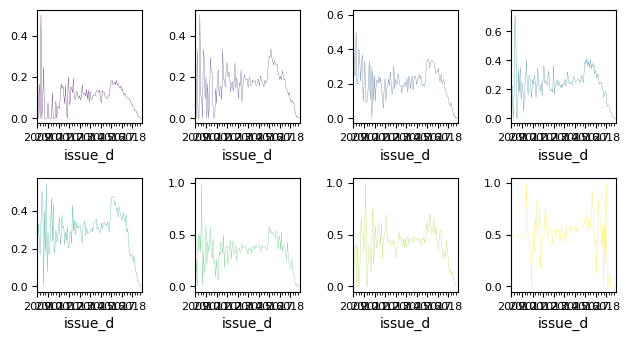

In [71]:
PD_monthly.plot(subplots=True,
          layout=(3, 4),
          sharex=False,
          sharey=False,
          colormap='viridis',
         fontsize=8,
         legend=False,
         linewidth=0.2);
plt.tight_layout();

# Estimate Long Term PD

In [89]:
econ_factor = pd.read_csv('econ_factor.csv')
econ_factor = econ_factor.loc[:, ['Time', 'int_rate', 'rci']]
econ_factor.index = econ_factor["Time"]
econ_factor.drop(columns="Time", inplace=True)
econ_forecast = pd.read_csv('econ_forecast.csv')
econ_forecast = econ_forecast.loc[:, ['Time', 'int_rate', 'rci']]
econ_forecast.index = econ_forecast["Time"]
econ_forecast.drop(columns="Time", inplace=True)

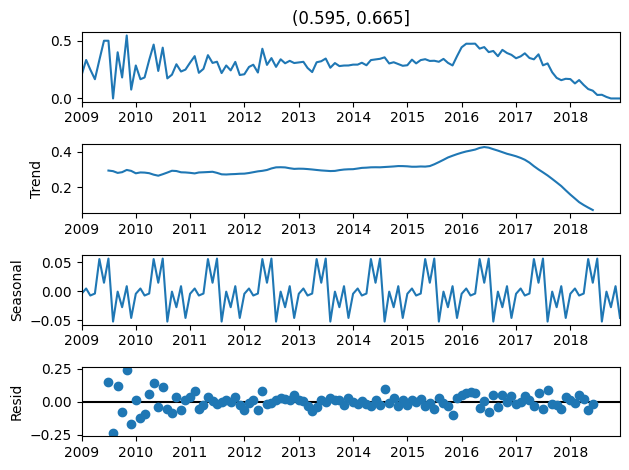

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(PD_monthly.iloc[:,4], model='additive')
fig = decomposition.plot()
plt.show()

# Class 1

In [ ]:
class_index = 0
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, class_index]

from statsmodels.tsa.statespace.sarimax import SARIMAX
auc_out = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factor),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit()
      auc_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

In [103]:
auc_out[np.argmin(np.array(auc_out)[:, 2])]

/var/folders/56/nfn25k9j2gb6nx4jj12sl_rh0000gn/T/ipykernel_26178/841137485.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  auc_out[np.argmin(np.array(auc_out)[:, 2])]


[(5, 0, 1), (0, 0, 0, 12), -416.375259469193]

In [ ]:
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factor),
              order=(5,0,1),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()
print(results_BB.summary().tables[1])

The best results show that the short-term interest rates and relative consumer prices index is useful for PD calibration

In [105]:
forecast_1 = results_BB.forecast(steps=60, exog=np.asarray(econ_forecast))

<AxesSubplot:xlabel='issue_d', ylabel='predicted_mean'>

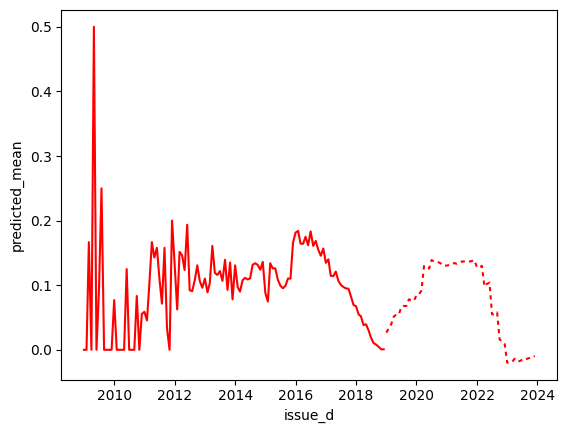

In [106]:
sns.lineplot(forecast_1, color = 'red', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,0], color = 'red')

# Class 2

In [ ]:
class_index = 1
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, class_index]

from statsmodels.tsa.statespace.sarimax import SARIMAX
auc_out = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factor),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit()
      auc_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

In [98]:
auc_out[np.argmin(np.array(auc_out)[:, 2])]

/var/folders/56/nfn25k9j2gb6nx4jj12sl_rh0000gn/T/ipykernel_26178/841137485.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  auc_out[np.argmin(np.array(auc_out)[:, 2])]


[(3, 0, 1), (1, 0, 0, 12), -320.9058416537544]

In [ ]:
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factor),
              order=(3,0,1),
              seasonal_order=(1,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()
print(results_BB.summary().tables[1])

In [101]:
forecast_2 = results_BB.forecast(steps=60, exog=np.asarray(econ_forecast))

<AxesSubplot:xlabel='issue_d', ylabel='predicted_mean'>

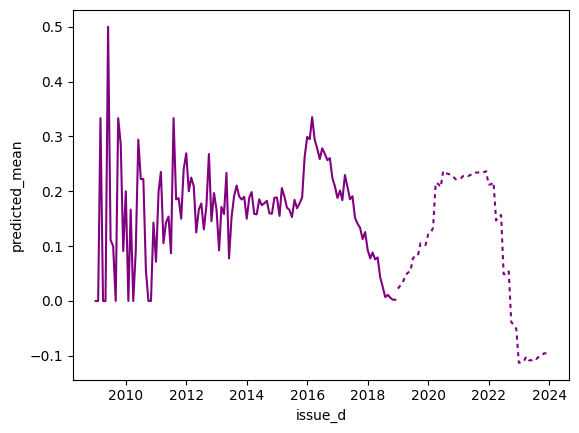

In [112]:
sns.lineplot(forecast_2, color = 'purple', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,1], color = 'purple')

# Class 3

In [ ]:
class_index = 2
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, class_index]

from statsmodels.tsa.statespace.sarimax import SARIMAX
auc_out = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factor),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit()
      auc_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

In [109]:
auc_out[np.argmin(np.array(auc_out)[:, 2])]

/var/folders/56/nfn25k9j2gb6nx4jj12sl_rh0000gn/T/ipykernel_26178/841137485.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  auc_out[np.argmin(np.array(auc_out)[:, 2])]


[(2, 0, 0), (1, 0, 0, 12), -325.54799025020935]

In [ ]:
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factor),
              order=(2,0,0),
              seasonal_order=(1,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()
print(results_BB.summary().tables[1])

<AxesSubplot:xlabel='issue_d', ylabel='predicted_mean'>

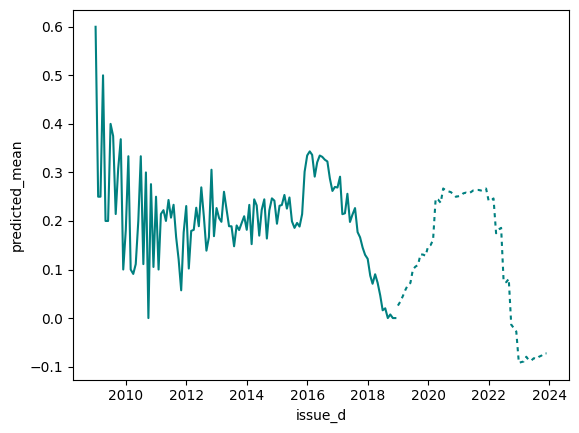

In [113]:
forecast_3 = results_BB.forecast(steps=60, exog=np.asarray(econ_forecast))
sns.lineplot(forecast_3, color = 'teal', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,2], color = 'teal')

# Class 4

In [ ]:
class_index = 3
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, class_index]

from statsmodels.tsa.statespace.sarimax import SARIMAX
auc_out = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factor),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit()
      auc_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

In [115]:
auc_out[np.argmin(np.array(auc_out)[:, 2])]

/var/folders/56/nfn25k9j2gb6nx4jj12sl_rh0000gn/T/ipykernel_26178/841137485.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  auc_out[np.argmin(np.array(auc_out)[:, 2])]


[(1, 1, 1), (1, 0, 0, 12), -315.93441748329474]

In [ ]:
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factor),
              order=(1,1,1),
              seasonal_order=(1,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()
print(results_BB.summary().tables[1])

<AxesSubplot:xlabel='issue_d', ylabel='predicted_mean'>

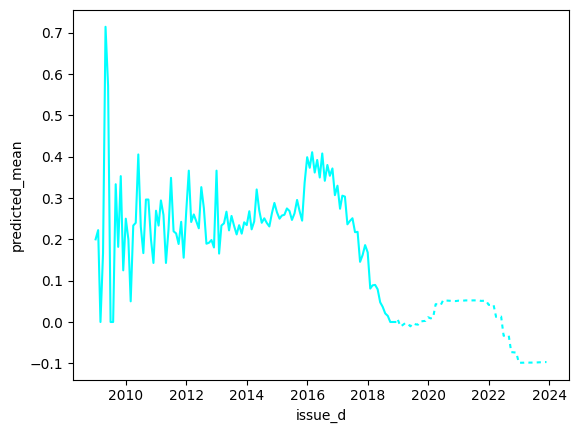

In [118]:
forecast_4 = results_BB.forecast(steps=60, exog=np.asarray(econ_forecast))
sns.lineplot(forecast_4, color = 'cyan', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,class_index], color = 'cyan')

# Class 5

In [ ]:
class_index = 4
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, class_index]

from statsmodels.tsa.statespace.sarimax import SARIMAX
auc_out = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factor),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit()
      auc_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

In [120]:
auc_out[np.argmin(np.array(auc_out)[:, 2])]

/var/folders/56/nfn25k9j2gb6nx4jj12sl_rh0000gn/T/ipykernel_26178/841137485.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  auc_out[np.argmin(np.array(auc_out)[:, 2])]


[(2, 1, 0), (2, 0, 0, 12), -334.72866124887634]

In [ ]:
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factor),
              order=(2,1,0),
              seasonal_order=(2,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()
print(results_BB.summary().tables[1])

<AxesSubplot:xlabel='issue_d', ylabel='predicted_mean'>

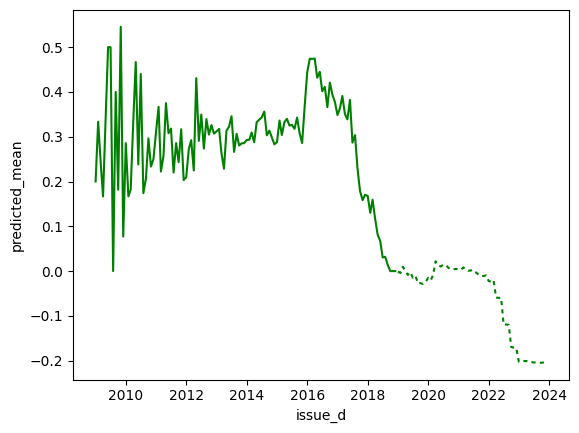

In [122]:
forecast_5 = results_BB.forecast(steps=60, exog=np.asarray(econ_forecast))
sns.lineplot(forecast_5, color = 'green', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,class_index], color = 'green')

# Class 6

In [ ]:
class_index = 5
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, class_index]

from statsmodels.tsa.statespace.sarimax import SARIMAX
auc_out = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factor),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit()
      auc_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

In [124]:
auc_out[np.argmin(np.array(auc_out)[:, 2])]

/var/folders/56/nfn25k9j2gb6nx4jj12sl_rh0000gn/T/ipykernel_26178/841137485.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  auc_out[np.argmin(np.array(auc_out)[:, 2])]


[(5, 0, 0), (2, 0, 0, 12), -225.38604643200486]

In [ ]:
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factor),
              order=(5,0,0),
              seasonal_order=(2,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()
print(results_BB.summary().tables[1])

<AxesSubplot:xlabel='issue_d', ylabel='predicted_mean'>

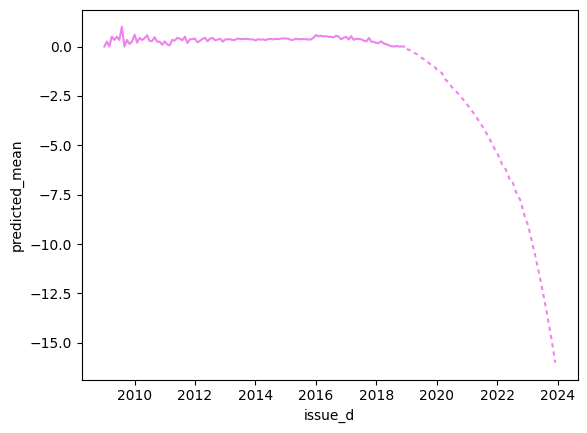

In [126]:
forecast_6 = results_BB.forecast(steps=60, exog=np.asarray(econ_forecast))
sns.lineplot(forecast_6, color = 'violet', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,class_index], color = 'violet')

# Class 7

In [ ]:
class_index = 6
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, class_index]

from statsmodels.tsa.statespace.sarimax import SARIMAX
auc_out = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factor),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit()
      auc_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

In [128]:
auc_out[np.argmin(np.array(auc_out)[:, 2])]

/var/folders/56/nfn25k9j2gb6nx4jj12sl_rh0000gn/T/ipykernel_26178/841137485.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  auc_out[np.argmin(np.array(auc_out)[:, 2])]


[(2, 0, 0), (3, 0, 0, 12), -210.5386304652846]

In [ ]:
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factor),
              order=(2,0,0),
              seasonal_order=(3,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()
print(results_BB.summary().tables[1])

<AxesSubplot:xlabel='issue_d', ylabel='predicted_mean'>

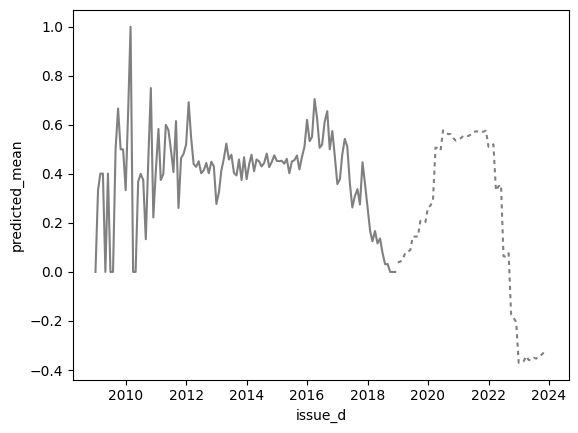

In [131]:
forecast_7 = results_BB.forecast(steps=60, exog=np.asarray(econ_forecast))
sns.lineplot(forecast_7, color = 'grey', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,class_index], color = 'grey')

# Class 8

In [ ]:
class_index = 7
# Define the search space.
p = range(1, 6)
d = range(0, 2)
q = range(0, 2)

# Create an interative list of ps, ds, qs.
from itertools import product
pdq = list(product(p, d, q))

# Seasonal parameters. One year back.
ps = range(0, 4)
ds = range(0, 1)
qs = range(0, 1)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]

# Train the models for a series and test multiple values.
y = PD_monthly.iloc[:, class_index]

from statsmodels.tsa.statespace.sarimax import SARIMAX
auc_out = []
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = SARIMAX(y,
                    exog=np.asarray(econ_factor),
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                    )
      results = mod.fit()
      auc_out.append([param, param_seasonal, results.aic])
      print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

In [133]:
auc_out[np.argmin(np.array(auc_out)[:, 2])]

/var/folders/56/nfn25k9j2gb6nx4jj12sl_rh0000gn/T/ipykernel_26178/841137485.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  auc_out[np.argmin(np.array(auc_out)[:, 2])]


[(2, 0, 0), (0, 0, 0, 12), -87.66652579808023]

In [ ]:
mod_BB = SARIMAX(y,
              exog=np.asarray(econ_factor),
              order=(2,0,0),
              seasonal_order=(0,0,0,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results_BB = mod_BB.fit()
print(results_BB.summary().tables[1])

<AxesSubplot:xlabel='issue_d', ylabel='predicted_mean'>

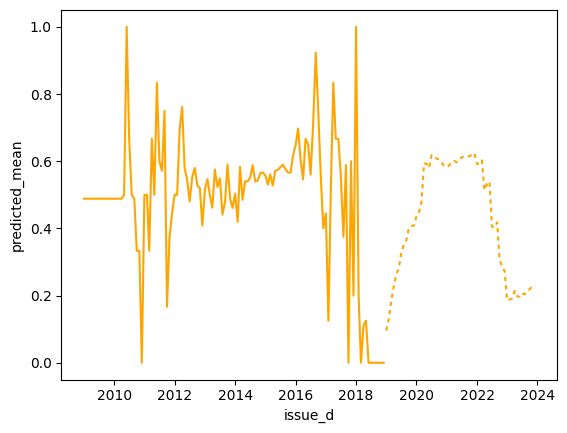

In [135]:
forecast_8 = results_BB.forecast(steps=60, exog=np.asarray(econ_forecast))
sns.lineplot(forecast_8, color = 'orange', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,class_index], color = 'orange')

# Overall Prediction

In [140]:
forecast_1 = forecast_1.clip(lower = 0)
forecast_2 = forecast_2.clip(lower = 0)
forecast_3 = forecast_3.clip(lower = 0)
forecast_4 = forecast_4.clip(lower = 0)
forecast_5 = forecast_5.clip(lower = 0)
forecast_6 = forecast_6.clip(lower = 0)
forecast_7 = forecast_7.clip(lower = 0)
forecast_8 = forecast_8.clip(lower = 0)

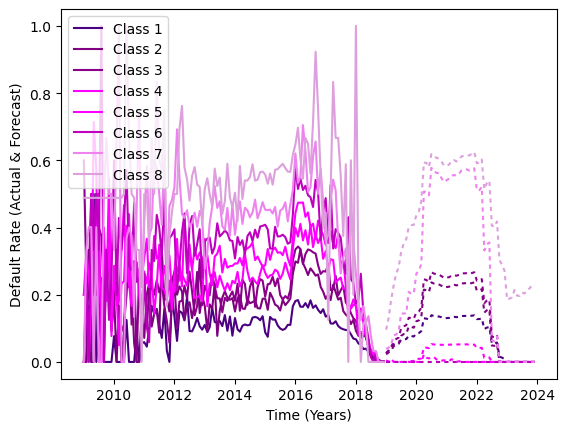

In [151]:
sns.lineplot(forecast_1, color = 'indigo', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,0], color = 'indigo', label = 'Class 1')
sns.lineplot(forecast_2, color = 'purple', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,1], color = 'purple', label = 'Class 2')
sns.lineplot(forecast_3, color = 'darkmagenta', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,2], color = 'darkmagenta', label = 'Class 3')
sns.lineplot(forecast_4, color = 'magenta', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,3], color = 'magenta', label = 'Class 4')
sns.lineplot(forecast_5, color = 'fuchsia', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,4], color = 'fuchsia', label = 'Class 5')
sns.lineplot(forecast_6, color = 'm', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,5], color = 'm', label = 'Class 6')
sns.lineplot(forecast_7, color = 'violet', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,6], color = 'violet', label = 'Class 7')
sns.lineplot(forecast_8, color = 'plum', dashes=(2, 2))
sns.lineplot(PD_monthly.iloc[:,7], color = 'plum', label = 'Class 8')
plt.xlabel('Time (Years)')
plt.ylabel('Default Rate (Actual & Forecast)')
plt.legend(loc = 'upper left')
plt.show()

# Class PD to Score Conversion (estimated)

In [160]:
pd.DataFrame(pbb_cuts).apply(lambda x: np.mean(df_sample[abs(df_sample.pd - x[0]) < 0.00005].score), axis = 1)

0           NaN
1    445.414634
2    428.924528
3    412.230769
4    390.621622
5    368.666667
6    350.833333
7    325.894737
8           NaN
dtype: float64

# The Scorecard Class Calibrarted:

- Class 1: Above 445
- Class 2: 429 - 445
- Class 3: 412 - 429
- Class 4: 391 - 412
- Class 5: 369 - 391
- Class 6: 351 - 369
- Class 7: 326 - 351
- Class 8: Below 326